In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext import data
from torchtext.datasets import AG_NEWS
import os
import gensim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)

# PyTorchのデータセットはデフォルトでは.dataに保存される
if not os.path.isdir('.data'):
    os.mkdir('.data')

C:\Users\gabriel\anaconda3\envs\torch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


device: cuda


In [2]:
train_set, test_set = AG_NEWS()
X_train = []
y_train = []
X_test = []
y_test = []
max_text_size = 0
for (label, text) in train_set:
    X_train.append(text)
    y_train.append(label)
    text_size = len(text.split())
    if  text_size > max_text_size:
        max_text_size = text_size
for (label, text) in test_set:
    X_test.append(text)
    y_test.append(label)
    text_size = len(text.split())
    if text_size > max_text_size:
        max_text_size = text_size
num_class = len(set(y_train + y_test)) #1,2,3,4

In [3]:
w2v_undebiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
w2v_debiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
w2v_dim = 300

In [4]:
def trans_text2vec(text, max_text_size, w2v_dim, w2v_model):
    x = torch.zeros(max_text_size, w2v_dim)
    for i, word in enumerate(text.split()):
        if word[-1] in [',', '.']:
            word = word[:-1]
        if word in w2v_model.key_to_index:
            x[i] += w2v_model[word]
    return x

class MyDataset(Dataset):
    def __init__(self, X, y, max_text_size, w2v_dim, w2v_model):
        self.X = X
        self.y = y
        self.num_data = len(X)
        self.max_text_size = max_text_size
        self.w2v_dim = w2v_dim
        self.w2v_model = w2v_model

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        x = trans_text2vec(self.X[i],
                           self.max_text_size,
                           self.w2v_dim,
                           self.w2v_model)
        y = self.y[i]
        return x, y

In [5]:
train_set = MyDataset(X_train, y_train, max_text_size, w2v_dim, w2v_undebiased)
test_set = MyDataset(X_test, y_test, max_text_size, w2v_dim, w2v_undebiased)

In [6]:
batch_size = 1000
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_class):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.ln = nn.Linear(hidden_dim, num_class)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.ln(x[:, -1])
        return x

In [8]:
model = LSTMClassifier(w2v_dim, 100, num_class).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [10]:
train_loss_log = []
eval_loss_log = []
eval_acc_log = []
for epoch in range(10):
    print('Epoch {}'.format(epoch+1))
    print('training')
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X = X.to(device)
        y = (y-1).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_loss_log.append(train_loss)
    print('train loss:{:.4}'.format(train_loss))

    print('evaluating')
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = (y-1).to(device) 
            pred = model(X)
            loss = loss_fn(pred, y)
            acc = (torch.max(pred, dim=1).indices == y).sum() / len(test_set)
    eval_loss_log.append(loss)
    eval_acc_log.append(acc)
    print('test loss:{:.4}, acc:{:.4}'.format(loss, acc))
    print('\n')

Epoch 1
training
train loss:1.3866034746170044
evaluating
test loss:1.386493444442749, acc:0.2499999850988388


Epoch 2
training
train loss:1.3864336013793945
evaluating
test loss:1.3863849639892578, acc:0.2499999850988388


Epoch 3
training
train loss:1.3863575458526611
evaluating
test loss:1.3863346576690674, acc:0.2499999850988388


Epoch 4
training
train loss:1.3863236904144287
evaluating


RuntimeError: CUDA out of memory. Tried to allocate 1.51 GiB (GPU 0; 10.00 GiB total capacity; 8.02 GiB already allocated; 0 bytes free; 8.03 GiB reserved in total by PyTorch)

In [ ]:
plt.plot(range(1, 101), train_loss_log)
plt.plot(range(1, 101), eval_loss_log)
plt.show()

In [ ]:
plt.plot(range(1, 101), eval_acc_log)
plt.show()

# 検定する

In [12]:
data = '''
Experience1
max acc: Epoch 100, 0.9064473509788513
max acc: Epoch 99, 0.8986841440200806
Experience2
max acc: Epoch 96, 0.9056578278541565
max acc: Epoch 95, 0.8989472985267639
Experience3
max acc: Epoch 93, 0.9065788984298706
max acc: Epoch 96, 0.8967105150222778
Experience4
max acc: Epoch 93, 0.9072368144989014
max acc: Epoch 100, 0.8882894515991211
Experience5
max acc: Epoch 99, 0.9056578278541565
max acc: Epoch 99, 0.8994736671447754
Experience6
max acc: Epoch 98, 0.9067105054855347
max acc: Epoch 94, 0.899078905582428
Experience7
max acc: Epoch 96, 0.9063157439231873
max acc: Epoch 100, 0.8997368216514587
Experience8
max acc: Epoch 100, 0.906842052936554
max acc: Epoch 98, 0.8980262875556946
Experience9
max acc: Epoch 100, 0.9067105054855347
max acc: Epoch 99, 0.8997368216514587
Experience10
max acc: Epoch 88, 0.906184196472168
max acc: Epoch 88, 0.8985525965690613
'''

In [13]:
data = [i for i in data.split() if i[0]=='0']
data

['0.9064473509788513',
 '0.8986841440200806',
 '0.9056578278541565',
 '0.8989472985267639',
 '0.9065788984298706',
 '0.8967105150222778',
 '0.9072368144989014',
 '0.8882894515991211',
 '0.9056578278541565',
 '0.8994736671447754',
 '0.9067105054855347',
 '0.899078905582428',
 '0.9063157439231873',
 '0.8997368216514587',
 '0.906842052936554',
 '0.8980262875556946',
 '0.9067105054855347',
 '0.8997368216514587',
 '0.906184196472168',
 '0.8985525965690613']

In [14]:
udb = []
db = []
for i, num in enumerate(data):
    if i%2 == 0:
        udb.append(float(num))
    else:
        db.append(float(num))

In [18]:
import matplotlib.pyplot as plt
from scipy import stats

## 正規性の検定

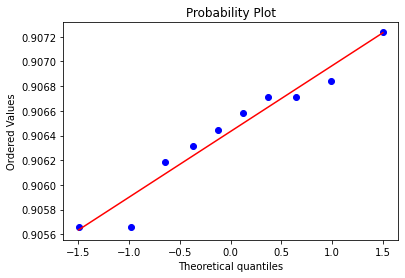

In [20]:
# Q-Qプロット
stats.probplot(udb, dist="norm", plot=plt)
plt.show()

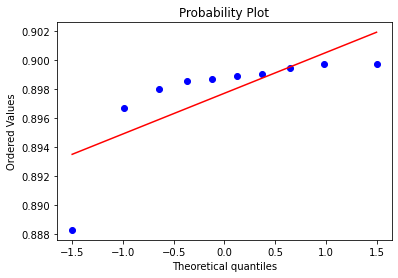

In [21]:
stats.probplot(db, dist="norm", plot=plt)
plt.show()

In [26]:
# シャピロ-ウィルク検定
W, p = stats.shapiro(udb)
print("{:.16f}".format(p))
W, p = stats.shapiro(db)
print("{:.16f}".format(p))

0.5884786248207092
0.0000478329129692


## 分散の検定

In [ ]:
import numpy as np

var_udb = np.var(udb)
var_db = np.var(db)

F = var_versicolor/var_setosa # 2.1443447981340951
# 両側5%検定
F_ = stats.f.ppf(0.975, len(udb)-1, len(db)-1) # alpha/2 #1.7621885352431106

if F > F_:
    print('「等分散である」を棄却')
else:
    print('「等分散である」を受容')

# 「等分散である」を棄却